### IMPORTAR LIBRERÍAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

## LECTURA DEL DATASET Y COMPLEMENTO DE INFORMACIÓN

In [2]:
# LECTURA DE LA BASE DE DATOS IMCOMPLETA

ruta = r"C:\Users\9 ----- SIG\Downloads\penaldo.xlsx"
df = pd.read_excel(ruta)
df.head(3)

,Temporada,Competición,Club,Fecha,Portero,Resultado
0,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2026-01-08,Ahmed Al-Kassar,Acertado
1,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2025-11-08,Luís Maximiano,Acertado
2,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2025-11-01,Orlando Mosquera,Acertado


Para la base de datos se toman de transfermarket 

In [3]:
# SIMULACIÓN DIRECCIÓN DE LOS COBROS

# SEMILLA PARA REPRODUCIBILIDAD
np.random.seed(42)

# TAMAÑO DE LA PORTERIA

ancho_arco = 7.32
alto_arco = 2.44


# SIMULACIÓN DEL DISPARO

def simular_disparo_cr7(resultado):
    if resultado == "Acertado":
        # Usamos Beta(0.5, 0.5) para que los tiros busquen los POSTES (0 o 1)
        # CR7 tiene un sesgo del 70% hacia su lado fuerte (izquierda del portero)
        if np.random.rand() < 0.7:
            x = np.random.beta(0.5, 2) * (ancho_arco / 3)
        else:
            x = ancho_arco - (np.random.beta(0.5, 2) * (ancho_arco / 3))
        
        y = np.random.beta(1, 3) * alto_arco # Mayoría rastreros o media altura
        a_puerta = 1
    else:
        tipo_fallo = np.random.choice(["desviado", "alto", "atajado"], p=[0.2, 0.2, 0.6])
        if tipo_fallo == "desviado":
            x = np.random.choice([-0.3, ancho_arco + 0.3])
            y = np.random.uniform(0, alto_arco)
            a_puerta = 0
        elif tipo_fallo == "alto":
            x = np.random.uniform(0, ancho_arco)
            y = alto_arco + np.random.uniform(0.1, 0.5)
            a_puerta = 0
        else: # Atajado: el tiro fue hacia el portero (más central)
            x = np.random.uniform(ancho_arco * 0.3, ancho_arco * 0.7)
            y = np.random.uniform(0.5, 1.8)
            a_puerta = 1
    return pd.Series([round(x, 2), round(y, 2), a_puerta])

# 3. APLICAR SIMULACIÓN
df[['disparo_x', 'disparo_y', 'a_puerta']] = df['Resultado'].apply(simular_disparo_cr7)

# 4. CLASIFICACIÓN DE ZONAS
def zona_porteria(x, y):
    if y > alto_arco or x < 0 or x > ancho_arco:
        return "Fuera"
    elif x < ancho_arco / 3:
        return "Izquierda"
    elif x > 2 * ancho_arco / 3:
        return "Derecha"
    else:
        return "Centro"

df["zona_porteria"] = df.apply(lambda fila: zona_porteria(fila["disparo_x"], fila["disparo_y"]), axis=1)
df["a_puerta"] = df["a_puerta"].astype(int)

# Ver resultado
df.head(3)

,Temporada,Competición,Club,Fecha,Portero,Resultado,disparo_x,disparo_y,a_puerta,zona_porteria
0,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2026-01-08,Ahmed Al-Kassar,Acertado,2.00,0.04,1,Izquierda
1,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2025-11-08,Luís Maximiano,Acertado,1.90,0.39,1,Izquierda
2,25/26,Saudi Pro League Saudi Pro League,Al-Nassr FC,2025-11-01,Orlando Mosquera,Acertado,0.16,0.66,1,Izquierda


## ANÁLISIS EXPLORATORIO

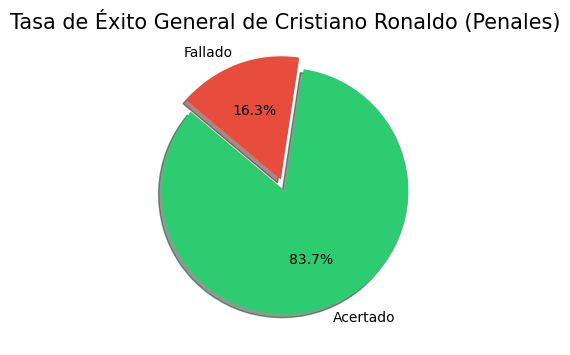

In [4]:
# RESUMEN GENERAL, TASA DE ÉXITO Y FRACASO

# Contar los valores de la columna Resultado
conteo = df['Resultado'].value_counts()

# Configurar los colores
colores = ['#2ecc71', '#e74c3c'] 

# explode para separar un poco la tajada de "Fallados"
explode = (0, 0.1) 

# Crear el gráfico
plt.figure(figsize=(4, 4))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=140, colors=colores, explode=explode,shadow=True)
plt.title('Tasa de Éxito General de Cristiano Ronaldo (Penales)', fontsize=15);

In [5]:
# Crear la tabla de contingencia entre Temporada y Resultado
temporada = pd.crosstab(df['Temporada'], df['Resultado'])

# Calcular el total de penales por temporada
temporada['Total'] = temporada['Acertado'] + temporada['Fallado']

# Calcular porcentajes
temporada['% Éxito'] = (temporada['Acertado'] / temporada['Total'] * 100).round(2)
temporada['% Fallo'] = (temporada['Fallado'] / temporada['Total'] * 100).round(2)

# Ordenar por temporada mas reciente
temporada = temporada.sort_index(ascending=False)

print("--- ANÁLISIS DE EFECTIVIDAD POR TEMPORADA ---")
temporada

--- ANÁLISIS DE EFECTIVIDAD POR TEMPORADA ---


Resultado,Acertado,Fallado,Total,% Éxito,% Fallo
Temporada,,,,,
25/26,5,1,6,83.33,16.67
24/25,12,4,16,75.00,25.00
23/24,9,1,10,90.00,10.00
22/23,9,0,9,100.00,0.00
21/22,4,1,5,80.00,20.00
20/21,14,3,17,82.35,17.65
19/20,14,2,16,87.50,12.50
18/19,9,1,10,90.00,10.00
17/18,8,2,10,80.00,20.00


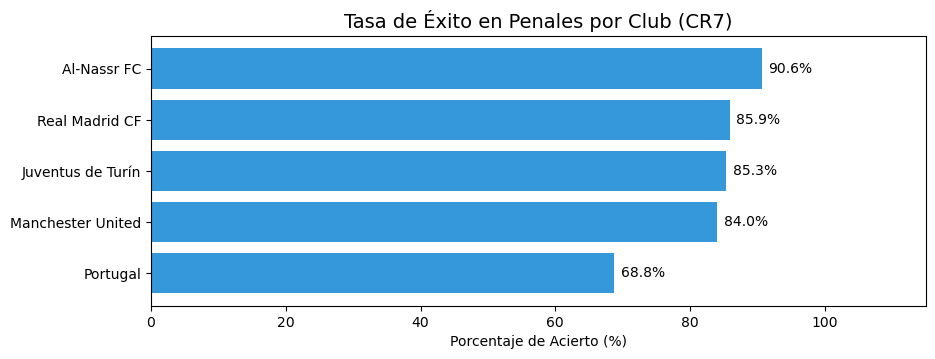

In [6]:
# Agrupar por Club y Resultado
por_club = pd.crosstab(df['Club'], df['Resultado'])

# Calcular el porcentaje de éxito
por_club['Total'] = por_club['Acertado'] + por_club['Fallado']
por_club['Tasa_Exito'] = (por_club['Acertado'] / por_club['Total']) * 100

# Ordenar por mayor tasa de éxito
por_club = por_club.sort_values('Tasa_Exito', ascending=True)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 3.5))
bars = plt.barh(por_club.index, por_club['Tasa_Exito'], color='#3498db')

# Añadir etiquetas de porcentaje al final de cada barra
for bar in bars:
    plt.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height()/2, 
        f'{bar.get_width():.1f}%', 
        va='center'
    )

plt.title('Tasa de Éxito en Penales por Club (CR7)', fontsize=14)
plt.xlabel('Porcentaje de Acierto (%)')
plt.xlim(0, 115); # espacio extra para que las etiquetas no se corten;

In [7]:
# Filtrar solo los penales que fueron 'Acertado'
anotados = df[df['Resultado'] == 'Acertado']

# Contar apariciones de cada portero y tomar los 5 primeros
top_5_porteros = anotados['Portero'].value_counts().head(5).reset_index()

# Renombrar columnas para que la tabla sea clara
top_5_porteros.columns = ['Portero', 'Goles de Penal']

print("--- TOP 5 PORTEROS MÁS GOLEADOS POR CR7 (PENALES) ---")
top_5_porteros

--- TOP 5 PORTEROS MÁS GOLEADOS POR CR7 (PENALES) ---


,Portero,Goles de Penal
0,Daniel Aranzubia,5
1,Hugo Lloris,4
2,Gorka Iraizoz,4
3,Miguel Ángel Moyá,4
4,Diego Mariño,3


In [8]:
# Filtrar solo los penales que fueron errados
errados = df[(df['Resultado'] == 'Fallado') & (df['zona_porteria'] != 'Fuera')]

# Contar apariciones de cada portero y tomar los 5 primeros
top_5_porteros = errados['Portero'].value_counts().head(5).reset_index()

# Renombrar columnas para que la tabla sea clara
top_5_porteros.columns = ['Portero', 'errados']

print("--- TOP 5 PORTEROS QUE MAS PENALES LE ATAJARON A CR7 (PENALES) ---")
top_5_porteros

--- TOP 5 PORTEROS QUE MAS PENALES LE ATAJARON A CR7 (PENALES) ---


,Portero,errados
0,Vladislav Stoyanov,2
1,Diego Alves,2
2,Caoimhín Kelleher,1
3,Chris Kirkland,1
4,Rob Green,1


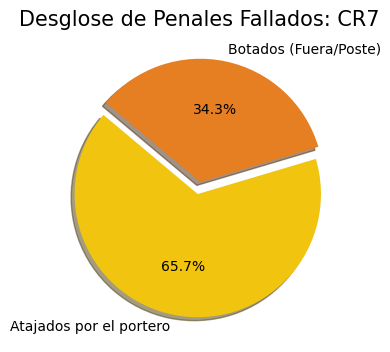

In [9]:
# Filtrar solo los penales fallados
df_fallados = df[df['Resultado'] == 'Fallado']

# Contar cuántos fueron atajado y cuántos botados
conteo_fallos = df_fallados['a_puerta'].value_counts()

# Mapear los nombres para la leyenda
labels = ['Atajados por el portero', 'Botados (Fuera/Poste)']
labels_ordenados = [labels[0] if i == 1 else labels[1] for i in conteo_fallos.index]

# Configurar colores
colores = ['#f1c40f', '#e67e22'] 

# 5. Crear el gráfico
plt.figure(figsize=(4, 4))
plt.pie(conteo_fallos, labels=labels_ordenados, autopct='%1.1f%%', startangle=140, colors=colores, explode=(0.05, 0.05), shadow=True)

plt.title('Desglose de Penales Fallados: CR7', fontsize=15);

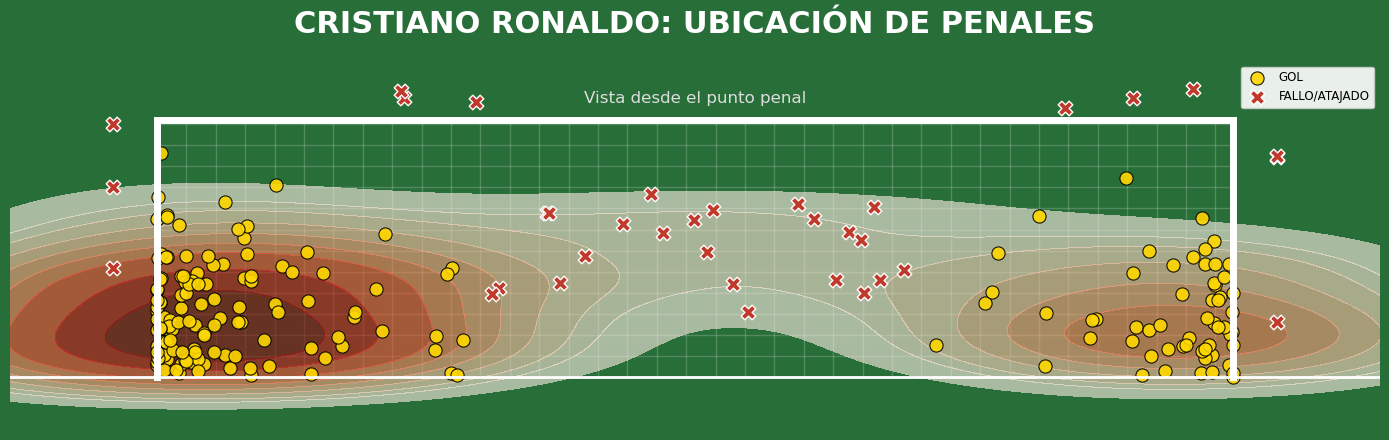

In [10]:
# 1. CONFIGURACIÓN ESTÉTICA (Modo Cancha)
# Reseteamos estilos anteriores
plt.style.use('default') 

fig, ax = plt.subplots(figsize=(14, 4.5))
# Color verde césped profesional
color_cesped = '#286e38' 
ax.set_facecolor(color_cesped)
fig.patch.set_facecolor(color_cesped)

# 2. DIBUJAR LA RED (Ahora en blanco/gris para contraste)
# Líneas verticales
for x in range(0, 74, 2):
    ax.plot([x/10, x/10], [0, 2.44], color='white', lw=1, zorder=0, alpha=0.2)
# Líneas horizontales
for y in range(0, 25, 2):
    ax.plot([0, 7.32], [y/10, y/10], color='white', lw=1, zorder=0, alpha=0.2)

# 3. EL MAPA DE CALOR (KDE PLOT)
# Filtramos para el plot
datos = df[
    (df['disparo_x'] > -1) & (df['disparo_x'] < 8.5) & 
    (df['disparo_y'] > -0.5) & (df['disparo_y'] < 3.5)
]

# Usamos 'Reds' o 'YlOrBr' para que parezca zona de peligro sobre el verde
sns.kdeplot(x=datos['disparo_x'], y=datos['disparo_y'], fill=True, cmap='Reds', alpha=0.6, thresh=0.15, levels=10, ax=ax, zorder=1)

# 4. DIBUJAR LOS POSTES (Marco Oficial)
plt.plot([0, 0], [0, 2.44], color='white', lw=5, zorder=3) # Poste Izquierdo
plt.plot([7.32, 7.32], [0, 2.44], color='white', lw=5, zorder=3) # Poste Derecho
plt.plot([0, 7.32], [2.44, 2.44], color='white', lw=5, zorder=3) # Travesaño
plt.plot([-1, 8.32], [0, 0], color='white', lw=2, zorder=3) # Línea de gol (suelo)

# 5. PUNTOS DE LOS DISPAROS
# Goles (Amarillo Dorado para que resalte en el verde)
goles = df[df['Resultado'] == 'Acertado']
ax.scatter(
    goles['disparo_x'], goles['disparo_y'], 
    s=90, color='#ffd700', edgecolors='black', linewidth=0.8, 
    alpha=0.9, label='GOL', zorder=2
)

# Fallos (X Rojas Oscuras)
fallos = df[df['Resultado'] == 'Fallado']
ax.scatter(
    fallos['disparo_x'], fallos['disparo_y'], 
    s=110, color='#c0392b', marker='X', edgecolors='white', linewidth=1, 
    alpha=1, label='FALLO/ATAJADO', zorder=2
)

# 6. TEXTOS Y DETALLES
plt.title('CRISTIANO RONALDO: UBICACIÓN DE PENALES', fontsize=22, color='white', fontweight='bold', pad=20)
plt.text(3.66, 2.6, 'Vista desde el punto penal', ha='center', color='#dddddd', fontsize=12)

# Ajustar límites
plt.xlim(-1, 8.32)
plt.ylim(-0.5, 3.0)

# Quitar ejes
plt.axis('off')

# Leyenda
legend = plt.legend(loc='upper right', frameon=True, fontsize=8.5, facecolor='white', framealpha=0.9)

plt.tight_layout();

## MODELO DE PREDICCIÓN

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [12]:
# PERFILES DE PORTEROS CONOCIDOS

perfiles_porteros = {
    'Jan Oblak': {'Altura': 188, 'Estilo': 'Posicional'},
    'Diego Alves': {'Altura': 190, 'Estilo': 'Especialista'},
    'Thibaut Courtois': {'Altura': 200, 'Estilo': 'Largo'},
    'Manuel Neuer': {'Altura': 193, 'Estilo': 'Cobertura'},
    'Gianluigi Buffon': {'Altura': 192, 'Estilo': 'Experiencia'}
}

# 2. Función para asignar perfil a cualquier portero
def asignar_perfil(nombre):
    # Si el portero es conocido, devolvemos su altura, si no, una media de 190cm
    if nombre in perfiles_porteros:
        return perfiles_porteros[nombre]['Altura']
    else:
        return 190 # Altura promedio de un portero de élite

# 3. Creamos la nueva columna en el dataframe
df['Altura_Portero'] = df['Portero'].apply(asignar_perfil)

In [13]:
# PREPARACIÓN DE LOS DATOS

caracteristicas = ['Altura_Portero', 'Club', 'Competición', 'Temporada']
objetivo = 'zona_porteria' # a donde irá el balón

X = df[caracteristicas].copy()
y = df[objetivo].copy()

In [14]:
# CODIFICACIÓN (Convertir texto a números)

codificadores = {}
for col in ['Club', 'Competición', 'Temporada']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str)) 
    codificadores[col] = le

In [15]:
# DIVISIÓN DEL DATASET
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. CREACIÓN Y ENTRENAMIENTO DEL MODELO

modelo_perfiles = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_perfiles.fit(X, y)

RandomForestClassifier(random_state=42)

In [16]:
# 5. EVALUACIÓN
predicciones = modelo_perfiles.predict(X_prueba)
precision = accuracy_score(y_prueba, predicciones)

print("RESULTADOS DEL MODELO PREDICTIVO")
print(f"Precisión General: {precision:.2%}")

RESULTADOS DEL MODELO PREDICTIVO
Precisión General: 69.77%


In [21]:
def predecir_penal_universal(nombre, altura_cm):
    # Definimos los nombres de las columnas exactamente como en el entrenamiento
    nombres_columnas = ['Altura_Portero', 'Club', 'Competición', 'Temporada']
    
    # Creamos el DataFrame de entrada con los nombres de las columnas
    contexto = pd.DataFrame([[
        altura_cm,
        codificadores['Club'].transform([df['Club'].iloc[0]])[0],
        codificadores['Competición'].transform([df['Competición'].iloc[0]])[0],
        codificadores['Temporada'].transform([df['Temporada'].iloc[0]])[0]
    ]], columns=nombres_columnas) # <--- AQUÍ está la clave
    
    # Ahora la predicción no dará Warning porque los nombres coinciden
    prediccion = modelo_perfiles.predict(contexto)[0]
    probabilidades = modelo_perfiles.predict_proba(contexto)[0]
    clases = modelo_perfiles.classes_
    
    print(f"\n--- ANÁLISIS PARA PORTERO {nombre} DE {altura_cm} CM ---")
    print(f"Dirección predicha: {prediccion.upper()}")
    print("Probabilidades:")
    for zona, prob in zip(clases, probabilidades):
        print(f" - {zona}: {prob:.1%}")

In [27]:
# EJEMPLO: Un portero que NO está en la base de datos (ej: un juvenil de 185cm)
predecir_penal_universal("Camilo Vargas",190)


--- ANÁLISIS PARA PORTERO Camilo Vargas DE 190 CM ---
Dirección predicha: IZQUIERDA
Probabilidades:
 - Centro: 0.0%
 - Derecha: 0.0%
 - Fuera: 18.3%
 - Izquierda: 81.7%


In [31]:
!jupyter nbconvert --to html --no-input "Predicción de penales.ipynb"

[NbConvertApp] Converting notebook Predicción de penales.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 564528 bytes to Predicción de penales.html
